# End to End Walkthrough

https://nixtlaverse.nixtla.io/neuralforecast/docs/tutorials/getting_started_complete.html

In [ ]:
import pandas as pd

In [ ]:
Y_df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')
Y_df

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0
...,...,...,...
373367,H99,744,24039.0
373368,H99,745,22946.0
373369,H99,746,22217.0
373370,H99,747,21416.0


In [ ]:
len(Y_df['unique_id'].unique())

414

This dataset contains 414 unique series with 900 observations on average. For this example and reproducibility’s sake, we will select only 10 unique IDs. 

In [ ]:
uids = Y_df['unique_id'].unique()[:10] # Select 10 ids to make the example faster
Y_df = Y_df.query('unique_id in @uids').reset_index(drop=True)
Y_df

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0
...,...,...,...
7475,H107,744,4316.0
7476,H107,745,4159.0
7477,H107,746,4058.0
7478,H107,747,3971.0


In [ ]:
from utilsforecast.plotting import plot_series

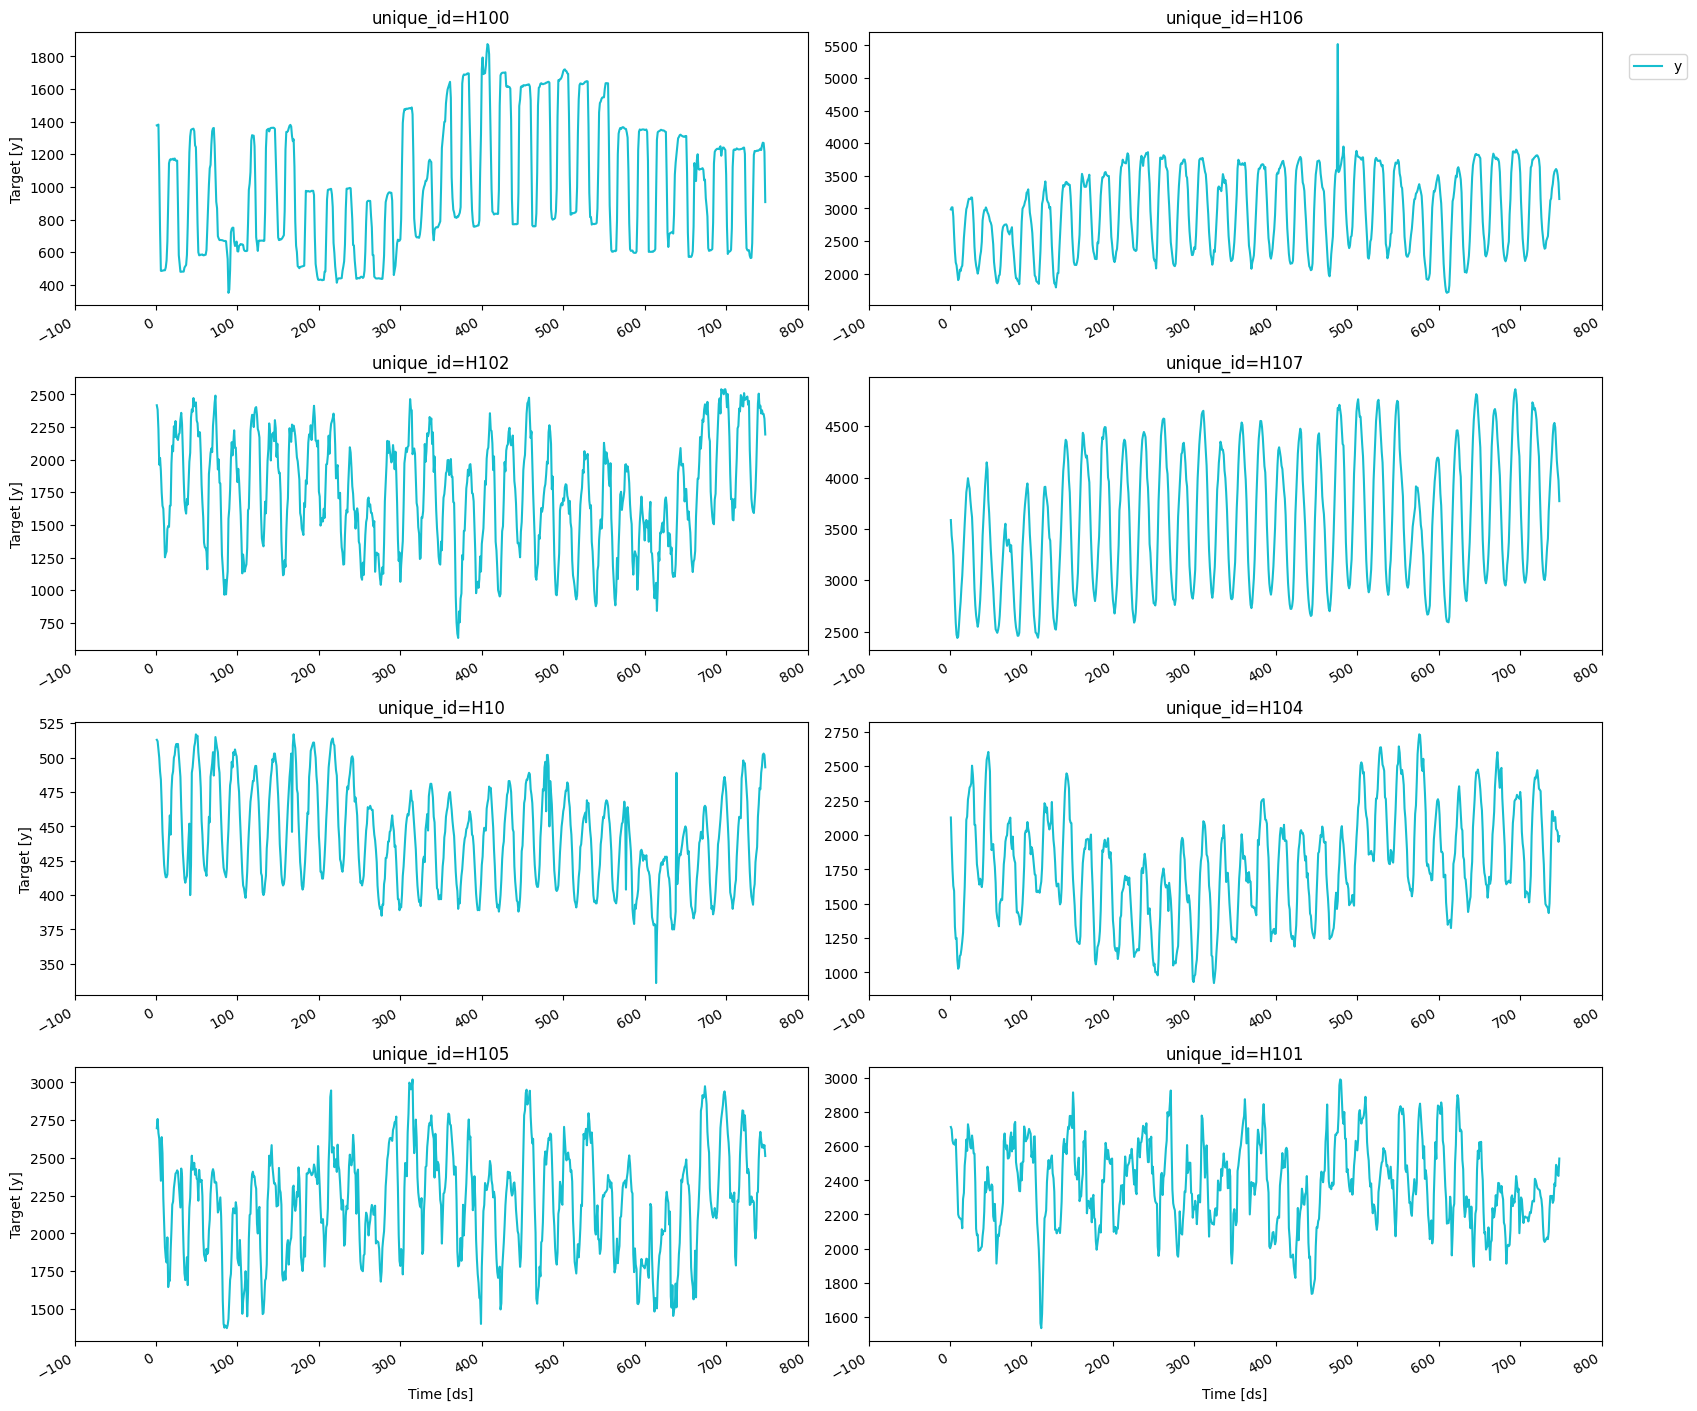

In [ ]:
plot_series(Y_df)

In [ ]:
import logging

import optuna
import ray.tune as tune
import torch

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.losses.pytorch import MQLoss

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)
torch.set_float32_matmul_precision('high')

In [ ]:
def config_nhits(trial):
    return {
        "input_size": trial.suggest_categorical(          # Length of input window
            "input_size", (48, 48*2, 48*3)                
        ),                                                
        "start_padding_enabled": True,                                          
        "n_blocks": 5 * [1],                              # Length of input window
        "mlp_units": 5 * [[64, 64]],                      # Length of input window
        "n_pool_kernel_size": trial.suggest_categorical(  # MaxPooling Kernel size
            "n_pool_kernel_size",
            (5*[1], 5*[2], 5*[4], [8, 4, 2, 1, 1])
        ),     
        "n_freq_downsample": trial.suggest_categorical(   # Interpolation expressivity ratios
            "n_freq_downsample",
            ([8, 4, 2, 1, 1],  [1, 1, 1, 1, 1])
        ),     
        "learning_rate": trial.suggest_float(             # Initial Learning rate
            "learning_rate",
            low=1e-4,
            high=1e-2,
            log=True,
        ),            
        "scaler_type": None,                              # Scaler type
        "max_steps": 1000,                                # Max number of training iterations
        "batch_size": trial.suggest_categorical(          # Number of series in batch
            "batch_size",
            (1, 4, 10),
        ),                   
        "windows_batch_size": trial.suggest_categorical(  # Number of windows in batch
            "windows_batch_size",
            (128, 256, 512),
        ),      
        "random_seed": trial.suggest_int(                 # Random seed   
            "random_seed",
            low=1,
            high=20,
        ),                      
    }

def config_lstm(trial):
    return {
        "input_size": trial.suggest_categorical(           # Length of input window
            "input_size",
            (48, 48*2, 48*3)
        ),   
        "encoder_hidden_size": trial.suggest_categorical(  # Hidden size of LSTM cells
            "encoder_hidden_size",
            (64, 128),
        ),  
        "encoder_n_layers": trial.suggest_categorical(     # Number of layers in LSTM
            "encoder_n_layers",
            (2,4),
        ),        
        "learning_rate": trial.suggest_float(              # Initial Learning rate
            "learning_rate",
            low=1e-4,
            high=1e-2,
            log=True,
        ),   
        "scaler_type": 'robust',                           # Scaler type
        "max_steps": trial.suggest_categorical(            # Max number of training iterations
            "max_steps",
            (500, 1000)
        ),          
        "batch_size": trial.suggest_categorical(           # Number of series in batch
            "batch_size",
            (1, 4)
        ),              
        "random_seed": trial.suggest_int(                  # Random seed
            "random_seed",
            low=1,
            high=20
        ),             
    }

As a general rule, we recommend setting num_samples higher than 20.

In [ ]:
nf = NeuralForecast(
    models=[
        AutoNHITS(h=48, config=config_nhits, loss=MQLoss(), backend='optuna', num_samples=5),
        AutoLSTM(h=48, config=config_lstm, loss=MQLoss(), backend='optuna', num_samples=2),
    ],
    freq=1,
)

In [ ]:
nf.fit(df=Y_df)

/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 1, 1, 1, 1] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2, 2, 2] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4, 4, 4] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categoric

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 1, 1, 1, 1] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2, 2, 2] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4, 4, 4] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distribut

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 1, 1, 1, 1] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2, 2, 2] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4, 4, 4] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distribut

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 1, 1, 1, 1] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2, 2, 2] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4, 4, 4] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distribut

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 1, 1, 1, 1] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2, 2, 2] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4, 4, 4] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distribut

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 12
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 17
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
Seed set to 18
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 17
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.


In [ ]:
fcst_df = nf.predict()
fcst_df.columns = fcst_df.columns.str.replace('-median', '')
fcst_df

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90,AutoLSTM,AutoLSTM-lo-90,AutoLSTM-lo-80,AutoLSTM-hi-80,AutoLSTM-hi-90
0,H1,749,598.398987,566.065491,562.988037,627.756958,633.895752,609.709473,394.206482,450.241638,766.752197,836.235962
1,H1,750,523.200012,508.161652,504.887939,578.163452,595.091431,546.601135,344.930145,394.840881,698.935120,767.983582
2,H1,751,486.337250,448.694061,464.488647,533.088989,557.788818,502.260040,311.773743,359.355316,648.499390,716.420593
3,H1,752,439.154144,410.910950,413.226288,486.093750,490.825806,472.348633,290.687408,336.337128,614.277161,681.544495
4,H1,753,390.320374,350.513153,346.662079,447.500580,463.828796,459.532776,282.878052,327.401123,600.091125,666.141846
...,...,...,...,...,...,...,...,...,...,...,...,...
475,H107,792,4568.661133,4096.375000,4160.873047,4911.261230,4941.312500,4464.501953,3494.041260,3783.209717,5164.813477,5451.560059
476,H107,793,4390.696289,3930.619385,4060.991699,4771.116211,4791.068848,4339.316406,3398.251953,3679.663330,5024.729492,5302.802734
477,H107,794,4191.275391,3751.688232,3870.859619,4572.841797,4647.546387,4210.500977,3295.754883,3568.748779,4879.245117,5150.511719
478,H107,795,4002.119141,3531.608643,3637.422363,4354.884766,4393.180664,4070.646729,3176.489502,3440.606934,4721.997070,4989.457031


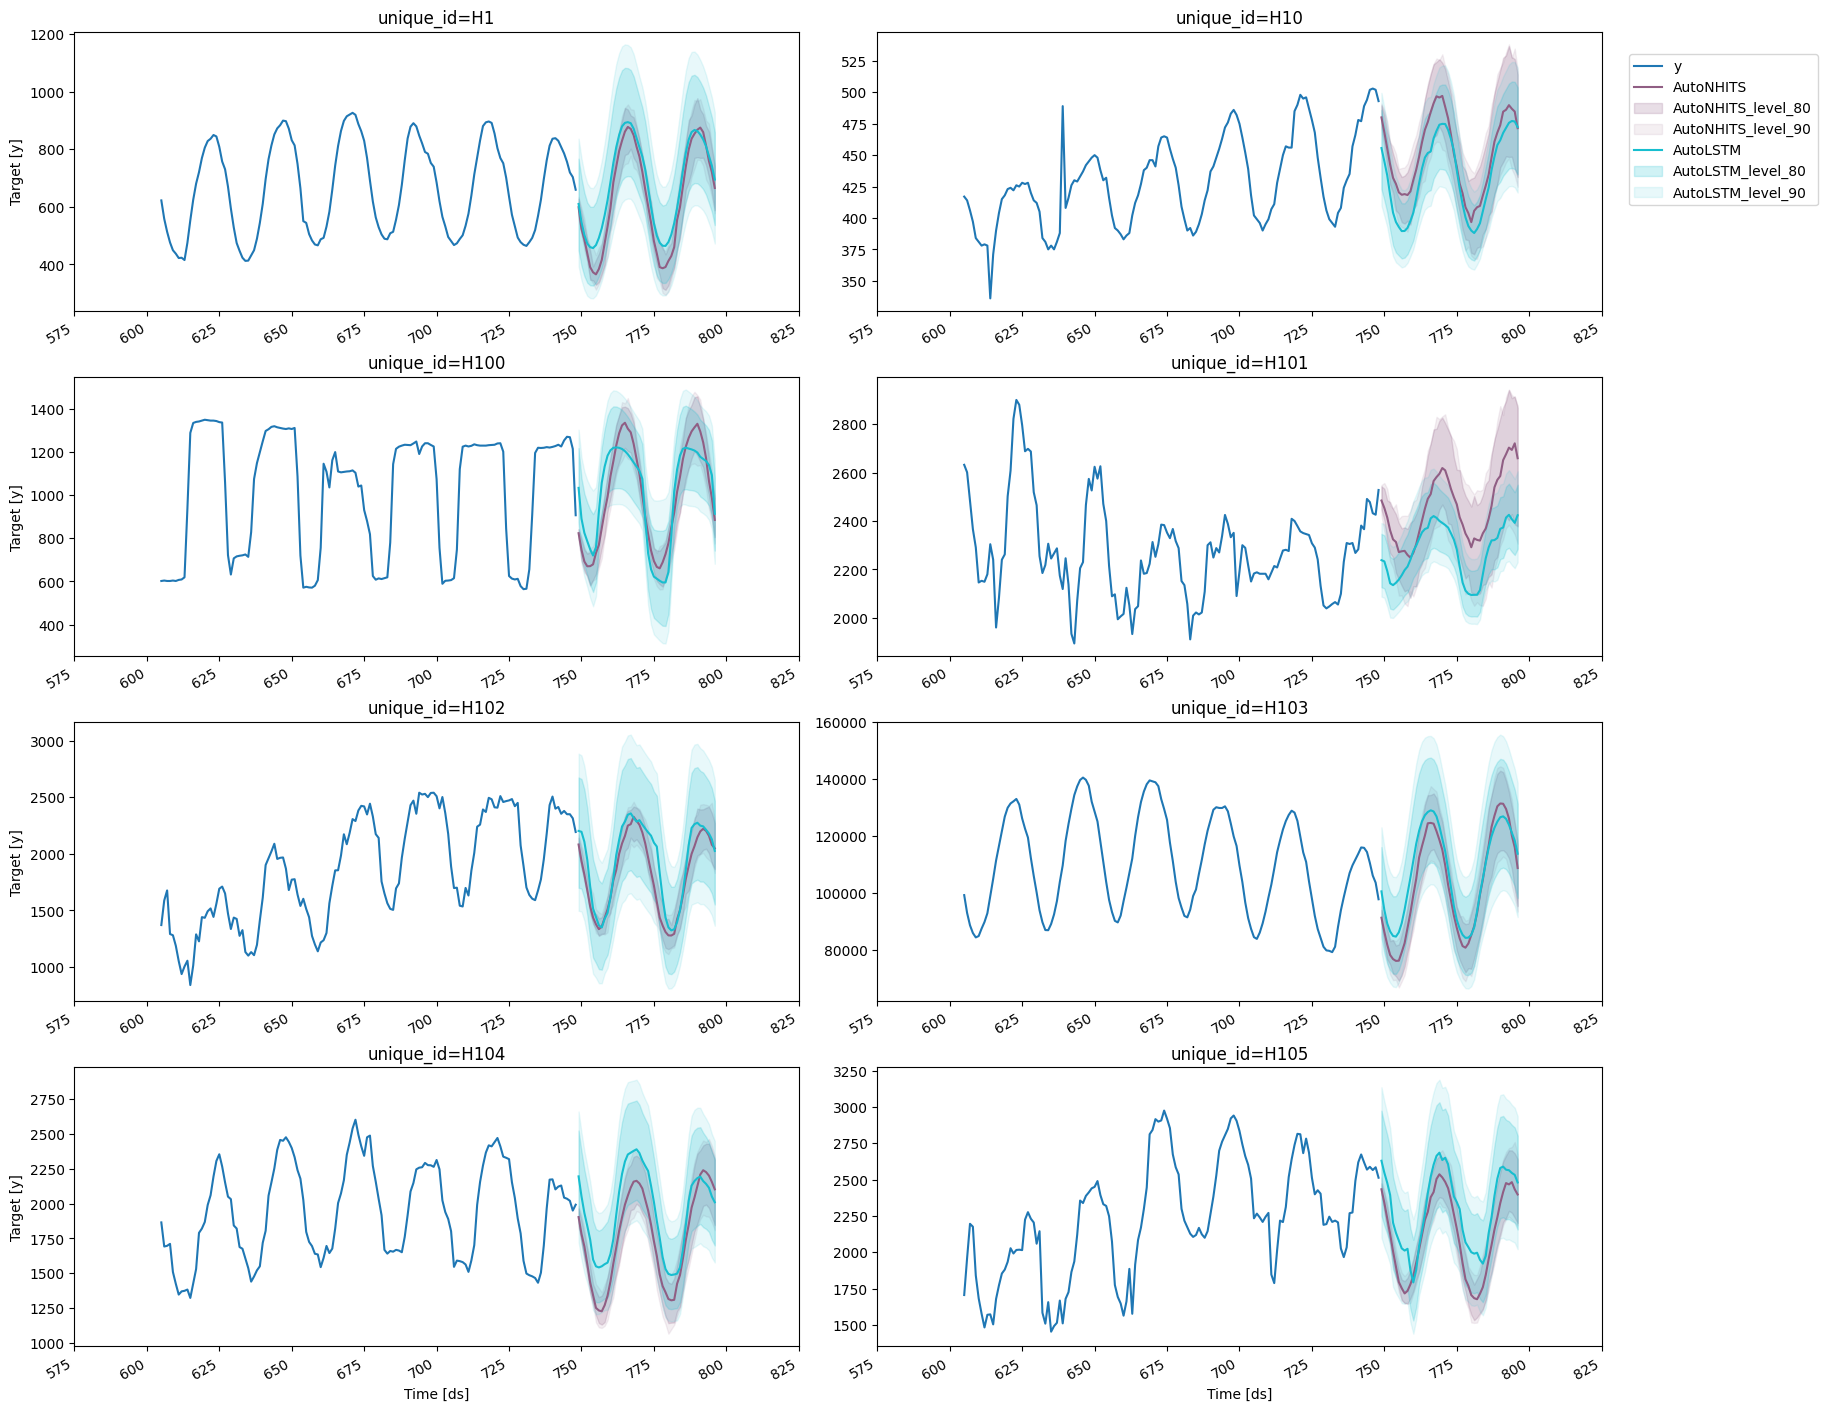

In [ ]:
plot_series(Y_df, fcst_df, plot_random=False, max_insample_length=48 * 3, level=[80, 90])

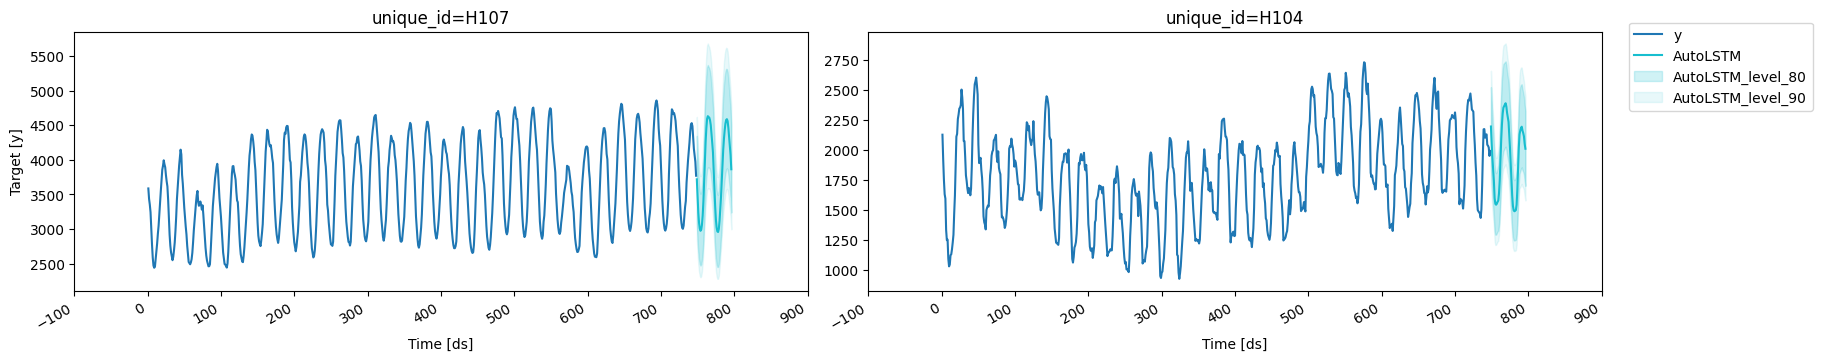

In [ ]:
# Plot to unique_ids and some selected models
plot_series(Y_df, fcst_df, models=["AutoLSTM"], ids=["H107", "H104"], level=[80, 90])

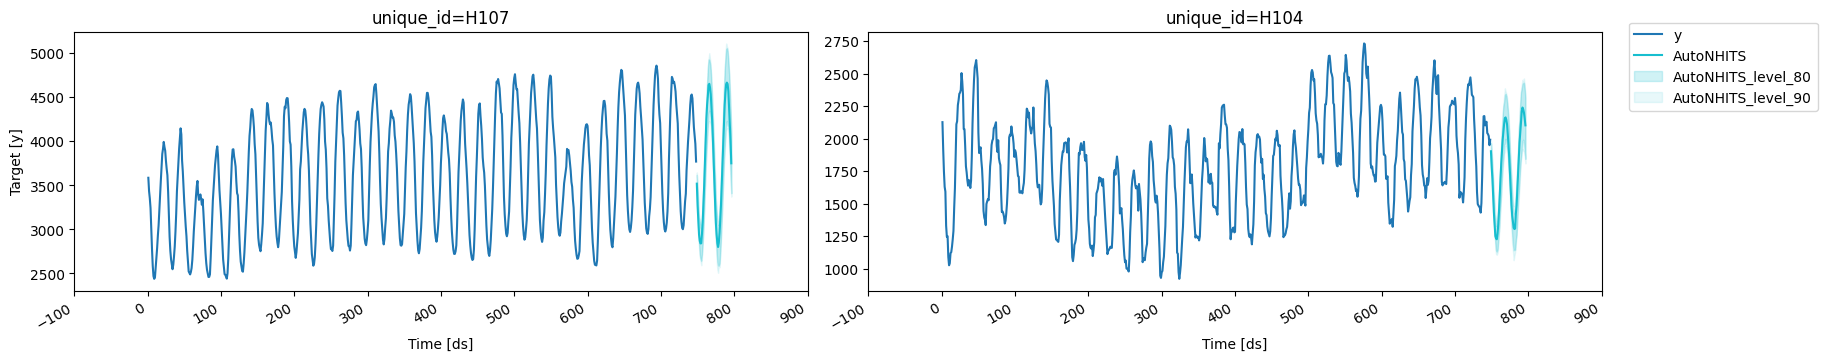

In [ ]:
# Explore other models 
plot_series(Y_df, fcst_df, models=["AutoNHITS"], ids=["H107", "H104"], level=[80, 90])

## Cross-Validation

In [ ]:
nf = NeuralForecast(
    models=[
        AutoNHITS(h=48, config=config_nhits, loss=MQLoss(), num_samples=5, backend="optuna"),
        AutoLSTM(h=48, config=config_lstm, loss=MQLoss(), num_samples=2, backend="optuna"), 
    ],
    freq=1,
)

In [ ]:
cv_df = nf.cross_validation(Y_df, step_size=48, n_windows=2)

/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 1, 1, 1, 1] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2, 2, 2] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4, 4, 4] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categoric

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 1, 1, 1, 1] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2, 2, 2] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4, 4, 4] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distribut

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 1, 1, 1, 1] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2, 2, 2] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4, 4, 4] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distribut

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 1, 1, 1, 1] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2, 2, 2] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4, 4, 4] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distribut

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 1, 1, 1, 1] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2, 2, 2, 2, 2] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 4, 4, 4, 4] which is of type list.
  warnings.warn(message)
/home/usr/miniconda3/envs/cal/lib/python3.12/site-packages/optuna/distribut

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 3
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
Seed set to 12
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
cv_df.columns = cv_df.columns.str.replace('-median', '')

In [ ]:
cv_df

,unique_id,ds,cutoff,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90,AutoLSTM,AutoLSTM-lo-90,AutoLSTM-lo-80,AutoLSTM-hi-80,AutoLSTM-hi-90,y
0,H1,653,652,660.093384,605.007446,600.966187,713.511597,721.153015,635.343994,339.338684,425.873718,860.067078,944.173645,664.0
1,H1,654,652,658.206665,603.392944,600.166565,718.343445,726.973389,596.949219,258.165741,355.700104,843.606689,952.923401,550.0
2,H1,655,652,622.825317,567.041016,574.495728,695.246399,703.279907,603.580566,291.485535,379.832642,833.696106,939.220947,544.0
3,H1,656,652,574.051636,508.902649,529.170166,646.266541,647.375977,579.369568,278.249725,365.842041,799.507080,901.227661,505.0
4,H1,657,652,538.675232,460.669891,485.306946,605.978821,594.757629,539.461670,242.487152,333.092957,752.540405,851.269531,483.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,H107,744,700,4664.958496,4044.734619,4229.420898,5231.840332,5437.194824,4739.290039,3630.004395,3871.125488,5720.106445,6165.418945,4316.0
956,H107,745,700,4515.140137,3888.271240,4117.624512,5070.047363,5258.267090,4611.795410,3522.436768,3762.448730,5542.973633,5969.447754,4159.0
957,H107,746,700,4326.569824,3729.671631,3962.067871,4946.641113,5083.455078,4466.027344,3391.079346,3633.514893,5351.615234,5758.674316,4058.0
958,H107,747,700,4163.281250,3624.961426,3807.186523,4862.065918,4951.923340,4308.275879,3242.290771,3490.489746,5153.514160,5541.383301,3971.0


In [ ]:
from IPython.display import display

Cutoff: 652


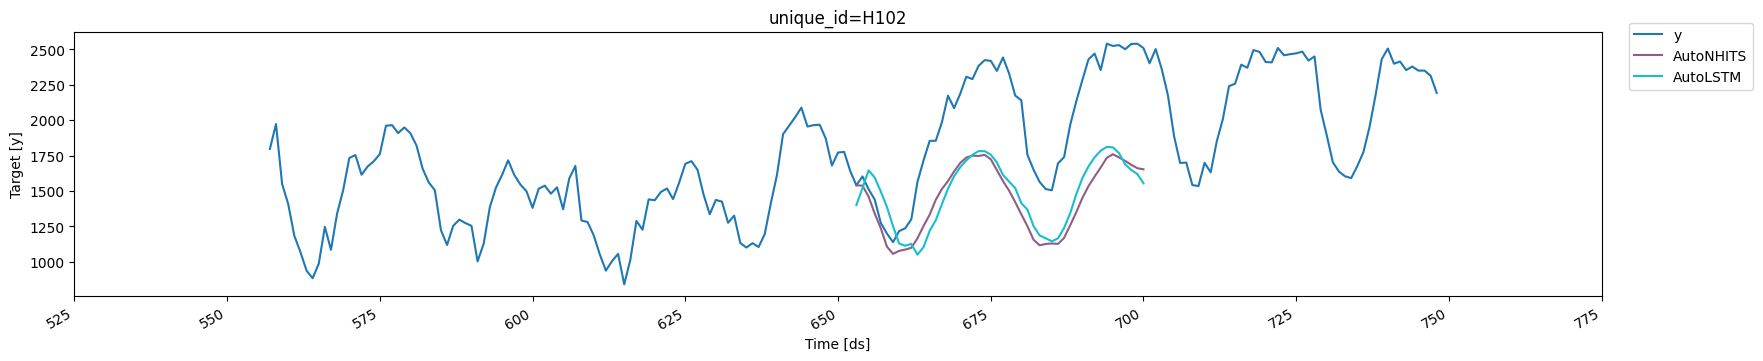

Cutoff: 700


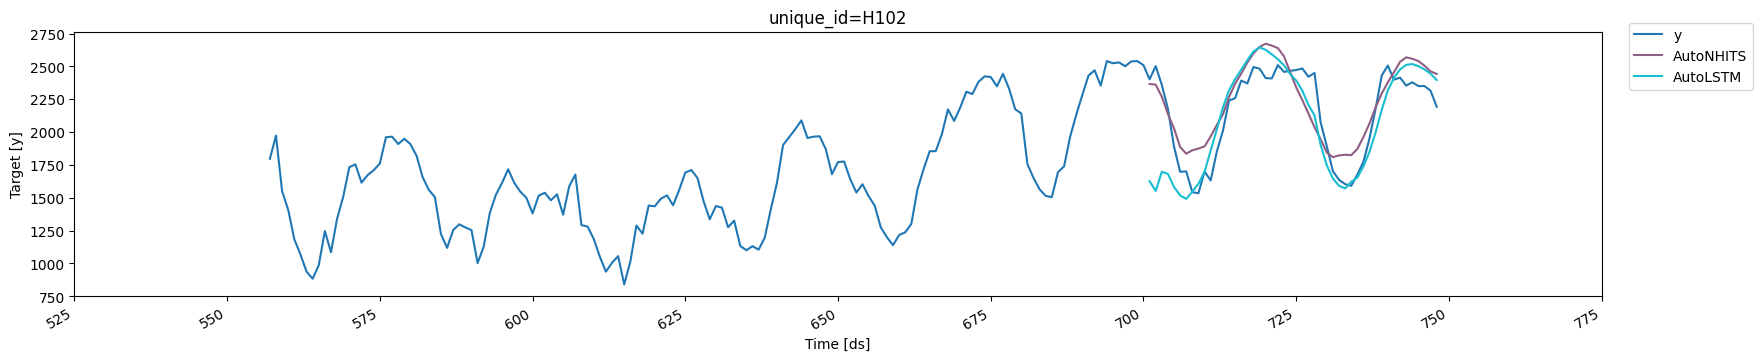

In [ ]:
for cutoff in cv_df['cutoff'].unique():
    print(f'Cutoff: {cutoff}')
    display(
        plot_series(
            Y_df,
            cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']),
            max_insample_length=48 * 4, 
            ids=['H102'],
        )
    )

In [ ]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mse, mae, rmse

In [ ]:
evaluation_df = evaluate(cv_df.drop(columns='cutoff'), metrics=[mse, mae, rmse])
evaluation_df['best_model'] = evaluation_df.drop(columns=['metric', 'unique_id']).idxmin(axis=1)
evaluation_df.head()

,unique_id,metric,AutoNHITS,AutoLSTM,best_model
0,H1,mse,2144.086495,3346.772862,AutoNHITS
1,H10,mse,183.449928,435.834880,AutoNHITS
2,H100,mse,62380.609204,18063.757395,AutoLSTM
3,H101,mse,54773.515997,35503.440550,AutoLSTM
4,H102,mse,196550.636864,201310.105656,AutoNHITS


In [ ]:
summary_df = evaluation_df.groupby(['metric', 'best_model']).size().sort_values().to_frame()
summary_df = summary_df.reset_index()
summary_df.columns = ['metric', 'model', 'nr. of unique_ids']
summary_df

,metric,model,nr. of unique_ids
0,mae,AutoLSTM,3
1,mse,AutoLSTM,3
2,rmse,AutoLSTM,3
3,mae,AutoNHITS,7
4,mse,AutoNHITS,7
5,rmse,AutoNHITS,7


In [ ]:
summary_df.query('metric == "mse"')

,metric,model,nr. of unique_ids
1,mse,AutoLSTM,3
4,mse,AutoNHITS,7


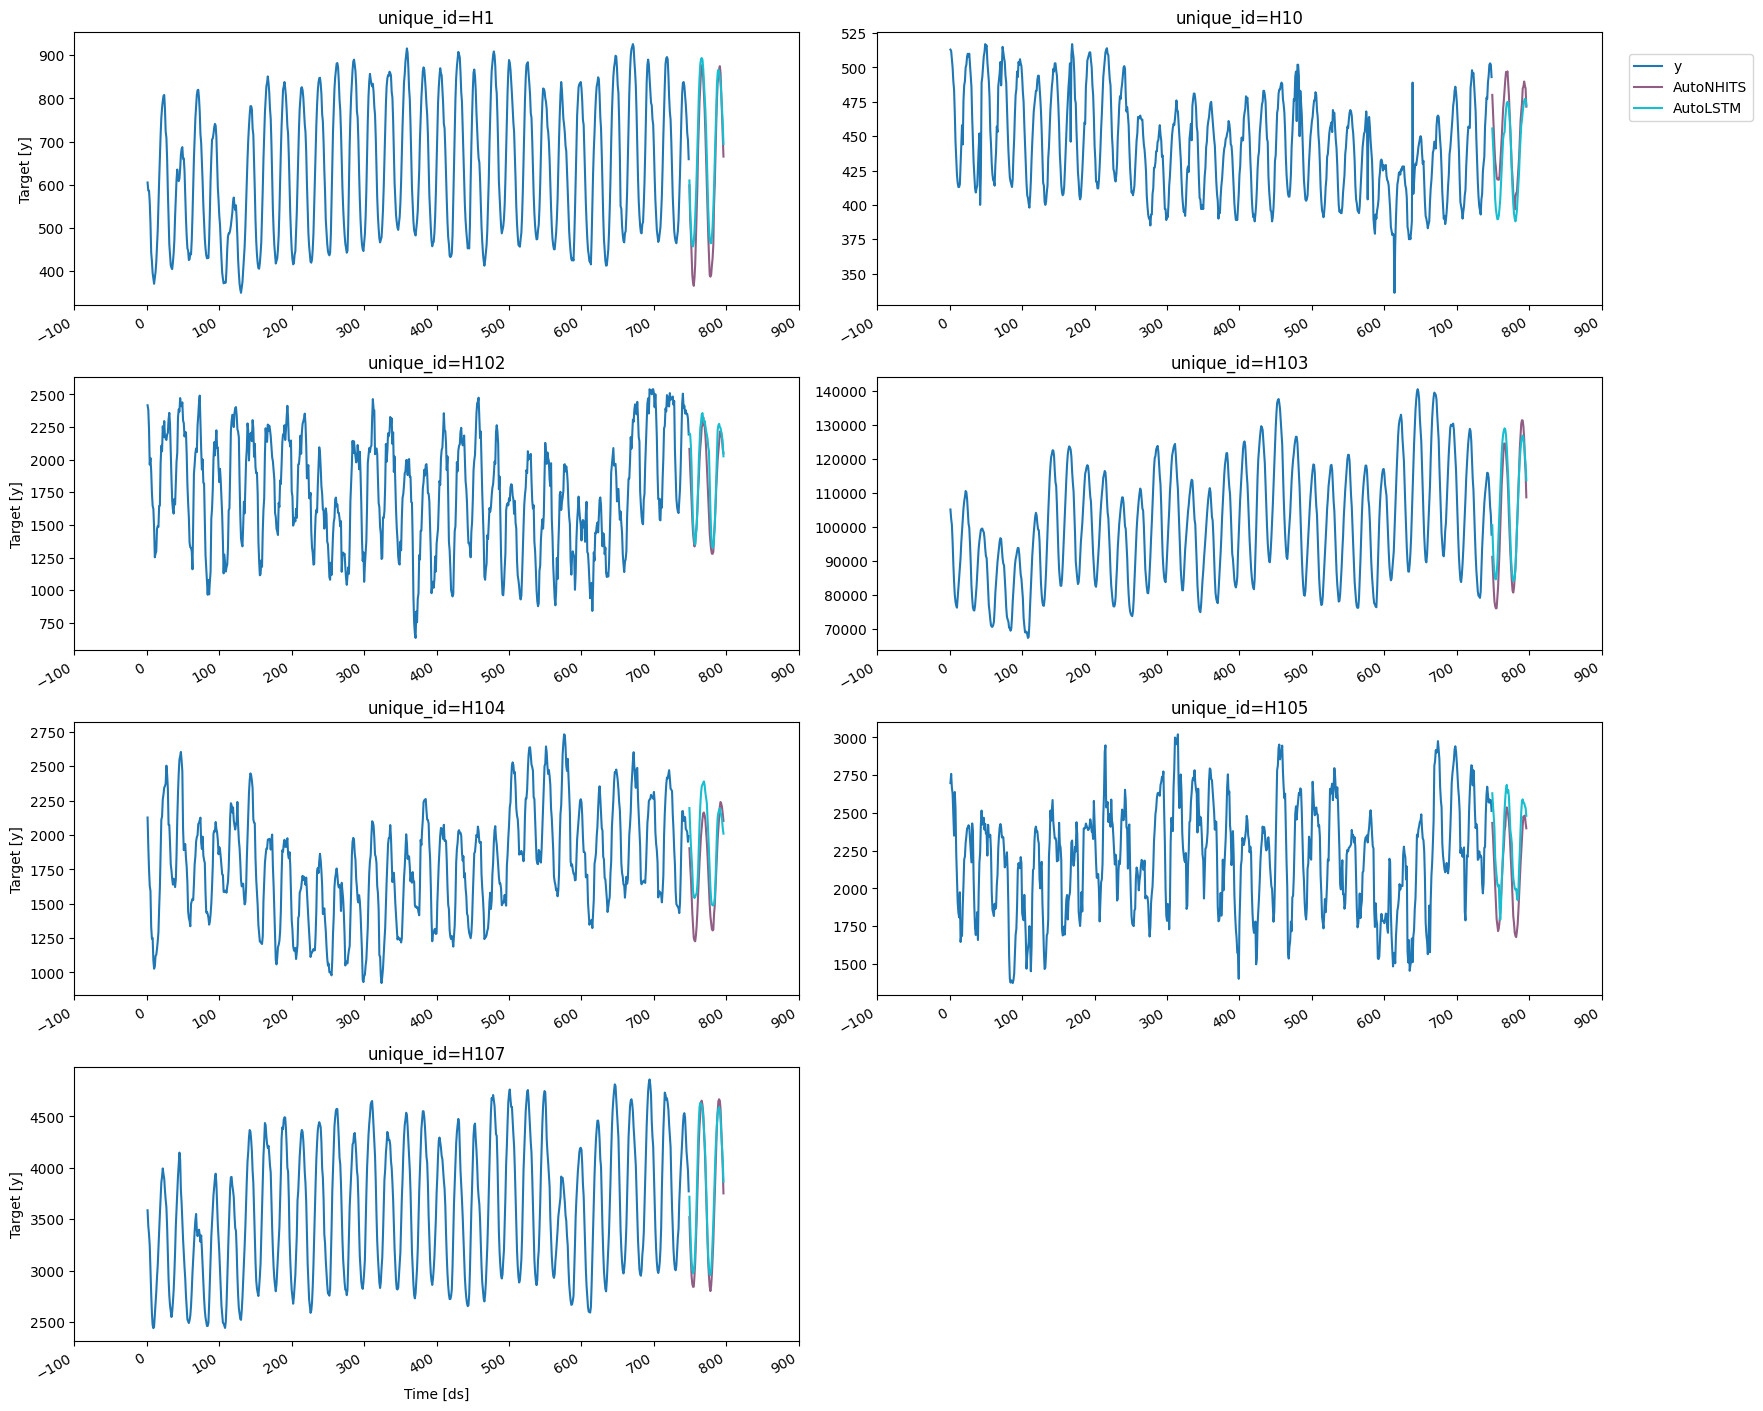

In [ ]:
nhits_ids = evaluation_df.query('best_model == "AutoNHITS" and metric == "mse"')['unique_id'].unique()

plot_series(Y_df, fcst_df, ids=nhits_ids)

In [ ]:
def get_best_model_forecast(forecasts_df, evaluation_df, metric):
    metric_eval = evaluation_df.loc[evaluation_df['metric'] == metric, ['unique_id', 'best_model']]
    with_best = forecasts_df.merge(metric_eval)
    res = with_best[['unique_id', 'ds']].copy()
    for suffix in ('', '-lo-90', '-hi-90'):
        res[f'best_model{suffix}'] = with_best.apply(lambda row: row[row['best_model'] + suffix], axis=1)
    return res

In [ ]:
prod_forecasts_df = get_best_model_forecast(fcst_df, evaluation_df, metric='mse')
prod_forecasts_df

,unique_id,ds,best_model,best_model-lo-90,best_model-hi-90
0,H1,749,598.398987,566.065491,633.895752
1,H1,750,523.200012,508.161652,595.091431
2,H1,751,486.337250,448.694061,557.788818
3,H1,752,439.154144,410.910950,490.825806
4,H1,753,390.320374,350.513153,463.828796
...,...,...,...,...,...
475,H107,792,4568.661133,4096.375000,4941.312500
476,H107,793,4390.696289,3930.619385,4791.068848
477,H107,794,4191.275391,3751.688232,4647.546387
478,H107,795,4002.119141,3531.608643,4393.180664


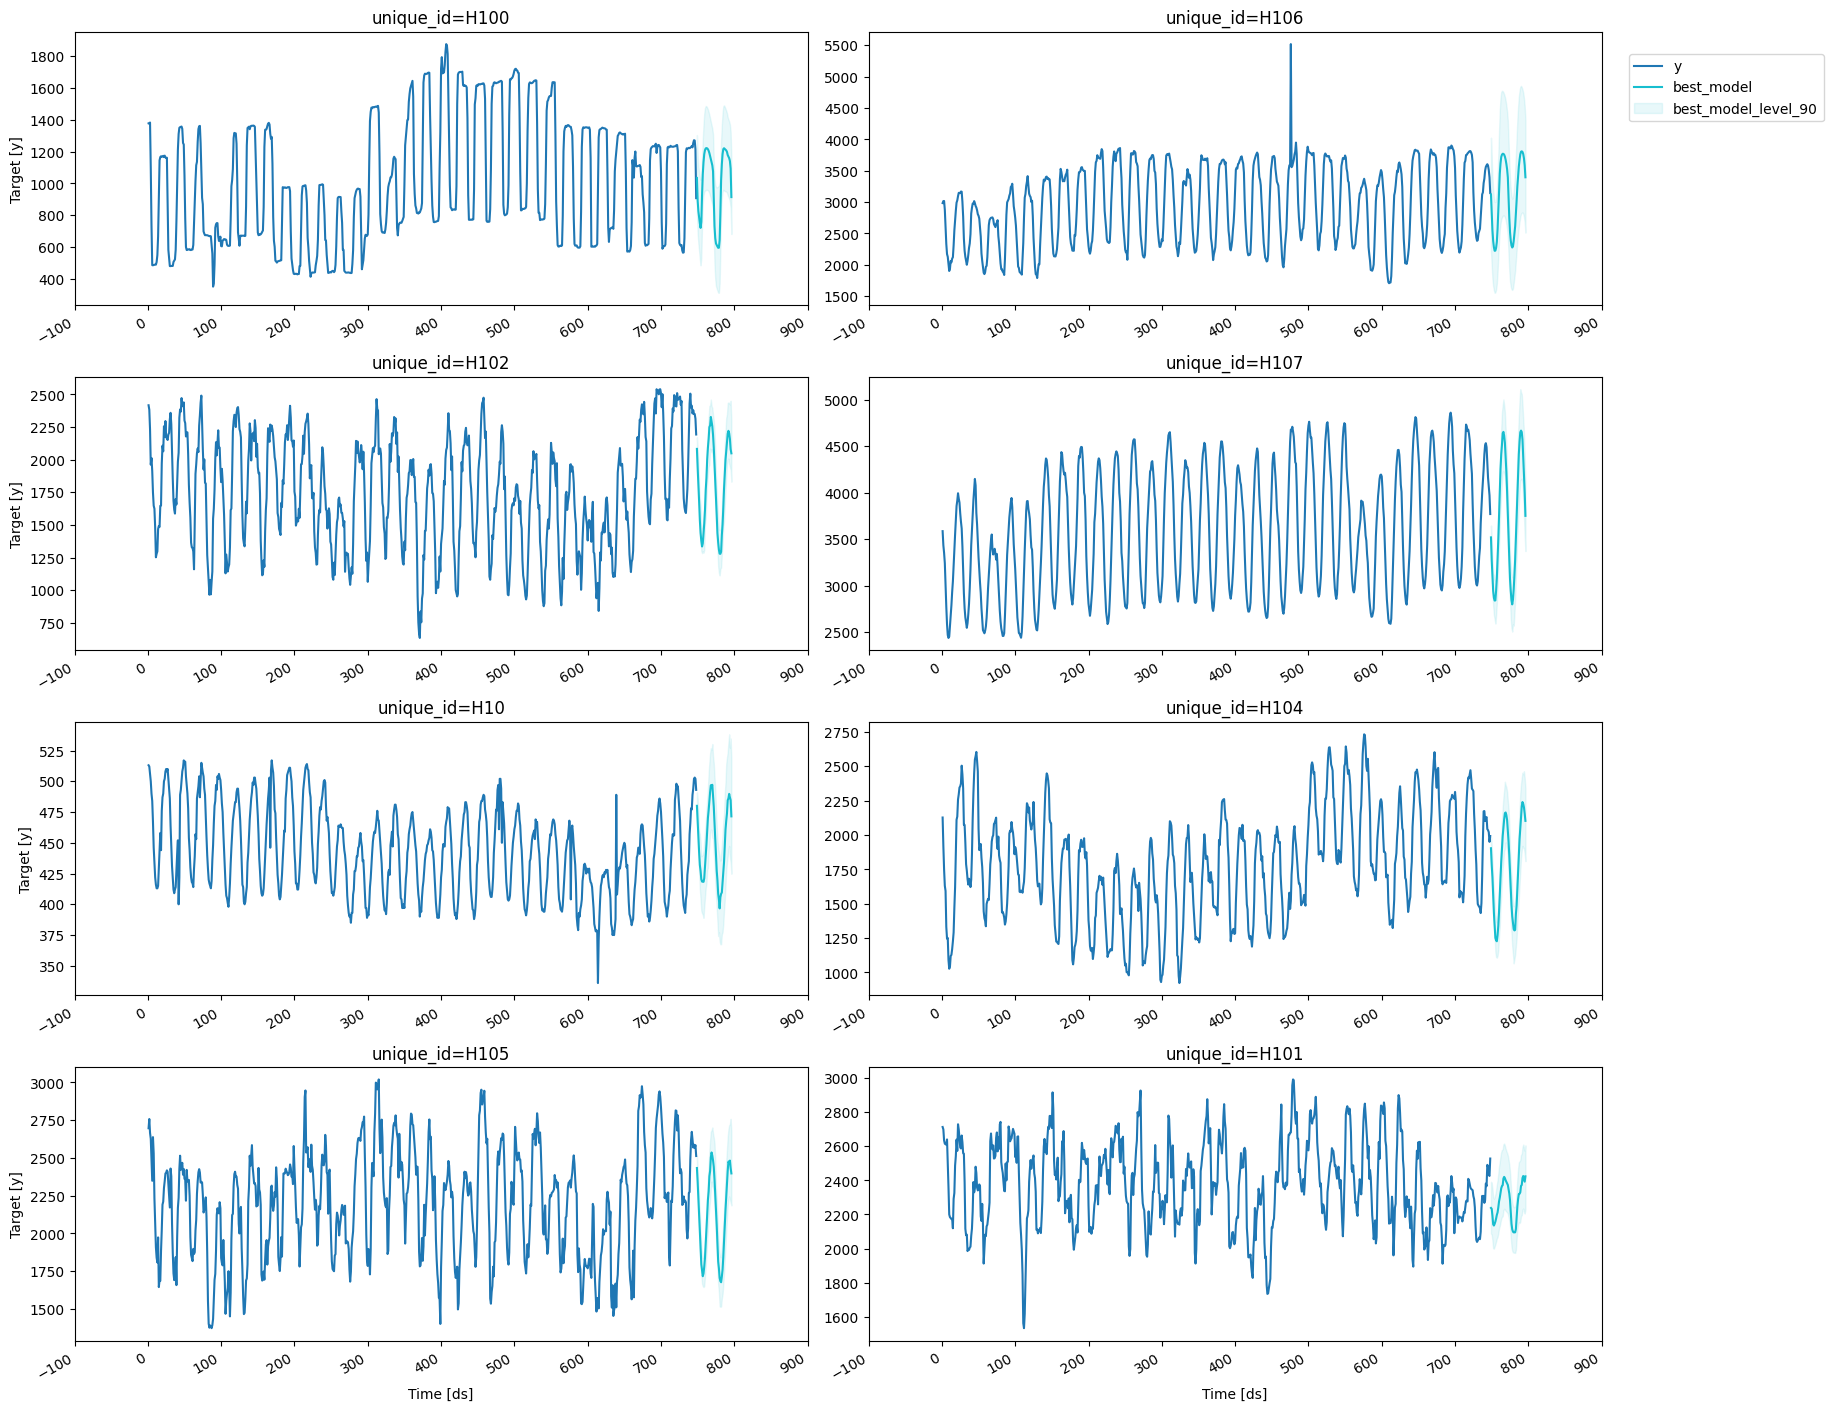

In [ ]:
plot_series(Y_df, prod_forecasts_df, level=[90])